# Extraction pass results.
With extraction pass, there isn't much to say. We have only one dataset and algorithm for it, and ot performed well. \
Too well one might say.

In [1]:
import wandb
import matplotlib.pyplot as plt
import torch
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification

In [2]:
wandb.login(key='')
hf_token = ''
api = wandb.Api()

project_name = "bert_extraction_ft"

runs = api.runs(f"sf-kozlowski-university-of-warsaw/{project_name}")
history = runs[0].history()
history.head()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\gusta\_netrc
wandb: Currently logged in as: gustaw-blachowski (sf-kozlowski-university-of-warsaw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


,_step,_runtime,train/loss,train/grad_norm,train/learning_rate,train/epoch,_timestamp,train/global_step,eval/B-VALIDITY-TEXT_recall,eval/I-VALIDITY-TEXT_recall,...,eval/I-ACTIVATION-TEXT_recall,eval/recall,eval/B-DISCOUNT-TEXT_recall,eval/O_recall,eval/I-PRODUCT-NAME_recall,eval/steps_per_second,eval/I-DISCOUNT-TEXT_recall,eval/overall_accuracy,eval/samples_per_second,eval/runtime
0,0,2.784845,1.6233,5.594084,0.00002,0.022472,1.743018e+09,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,3.047794,0.8979,4.599450,0.00002,0.044944,1.743018e+09,20,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,3.289133,0.5867,8.126394,0.00002,0.067416,1.743018e+09,30,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3.525965,0.4117,3.247190,0.00002,0.089888,1.743018e+09,40,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,3.760031,0.2898,1.902974,0.00002,0.112360,1.743018e+09,50,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Training statistics.

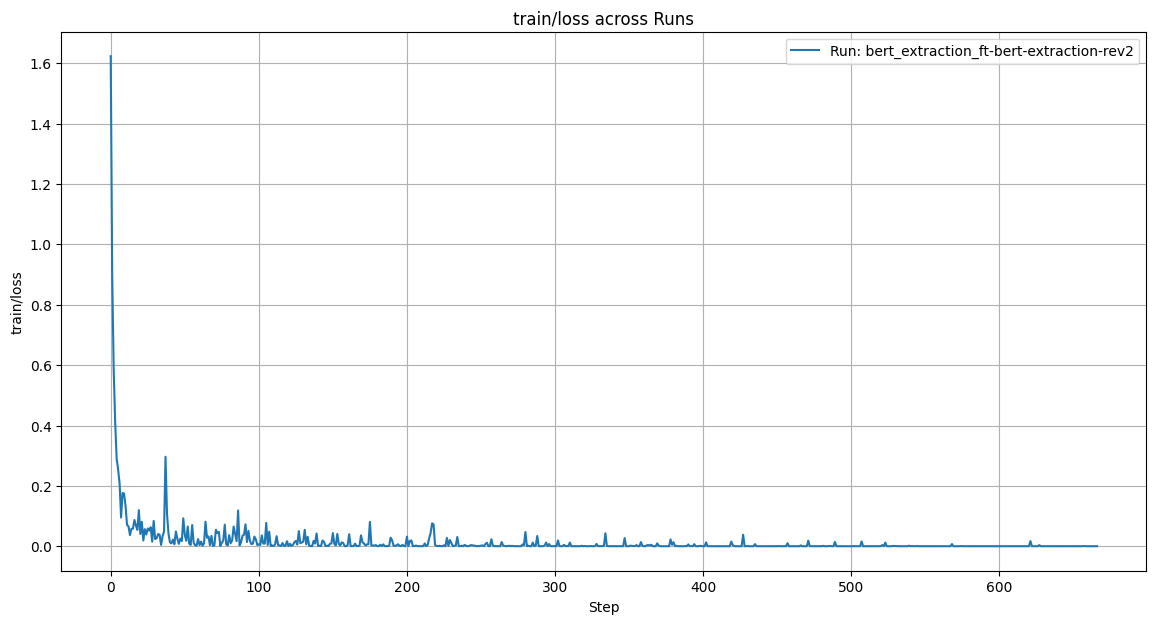

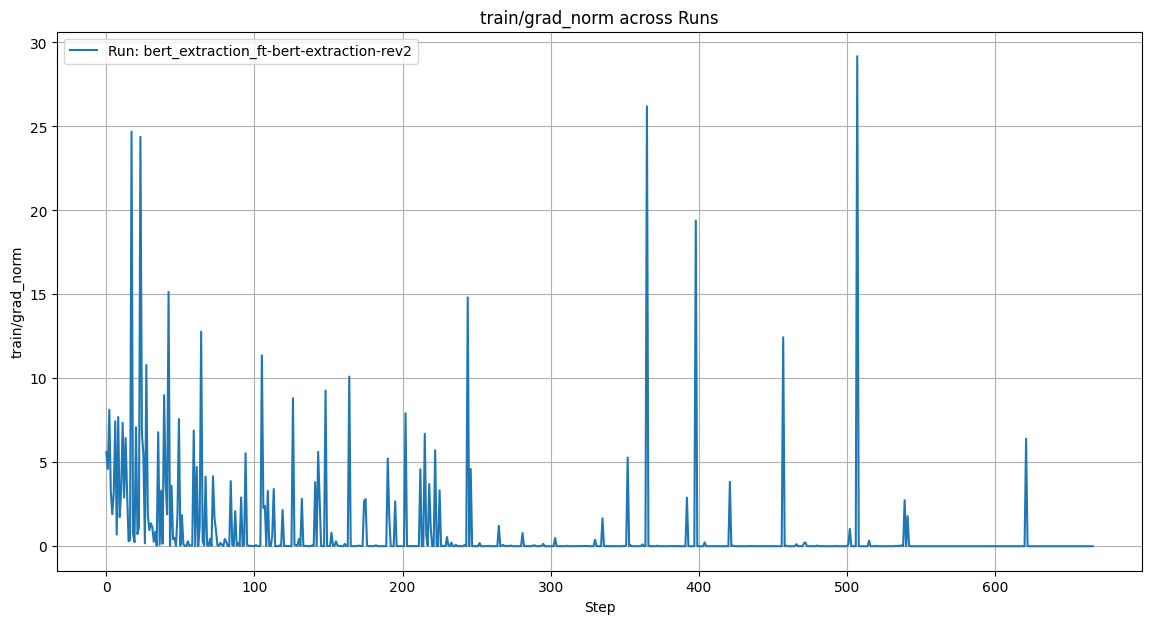

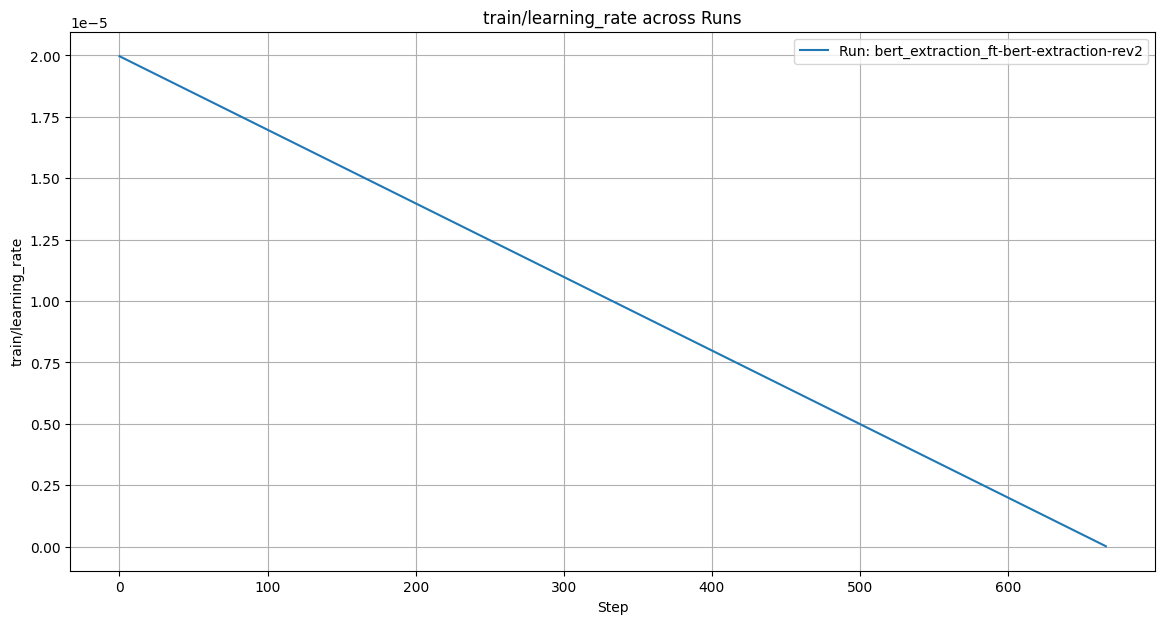

In [3]:
def plot_runs_data(runs, metric):
    plt.figure(figsize=(14, 7))
    for run in runs:
        hist = run.scan_history()
        # Convert to DataFrame
        hist_df = pd.DataFrame(hist)
        if hist_df.empty:
            continue
        if metric in hist_df.columns:
            # Filter out nans
            data = hist_df[metric].dropna()
            labels = list(range(len(data)))
            plt.plot(labels, data, label=f"Run: {run.name}")

    plt.xlabel("Step")
    plt.ylabel(metric)
    plt.title(f"{metric} across Runs")
    plt.legend()
    plt.grid()
    plt.show()

plot_runs_data(runs, "train/loss")
plot_runs_data(runs, "train/grad_norm")
plot_runs_data(runs, "train/learning_rate")

# Evaluation statistics.

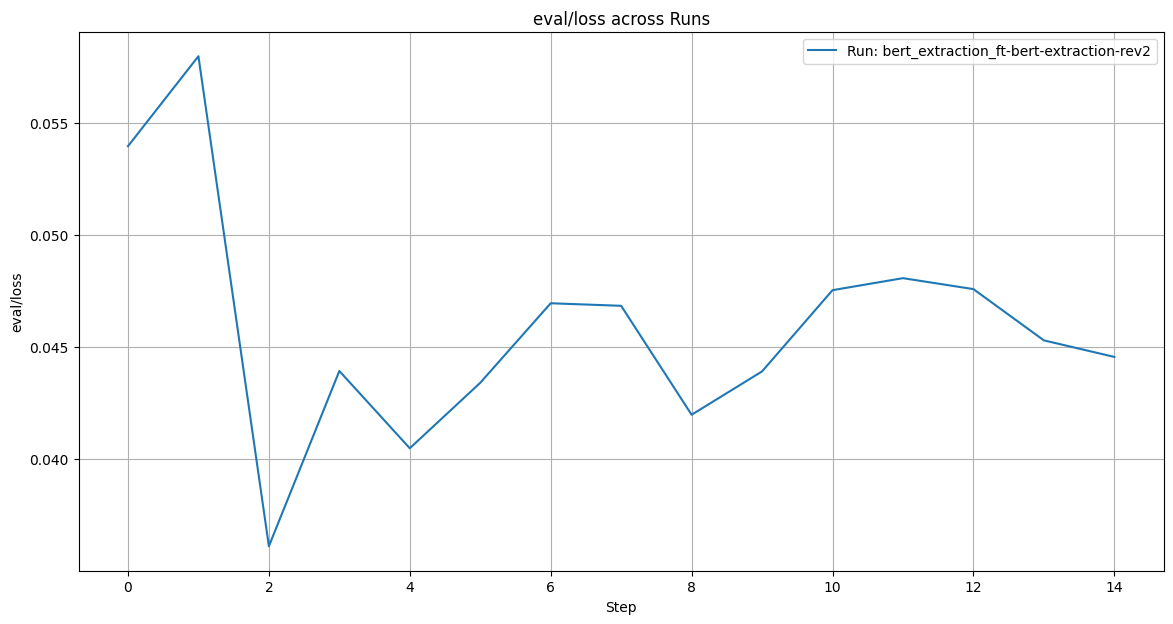

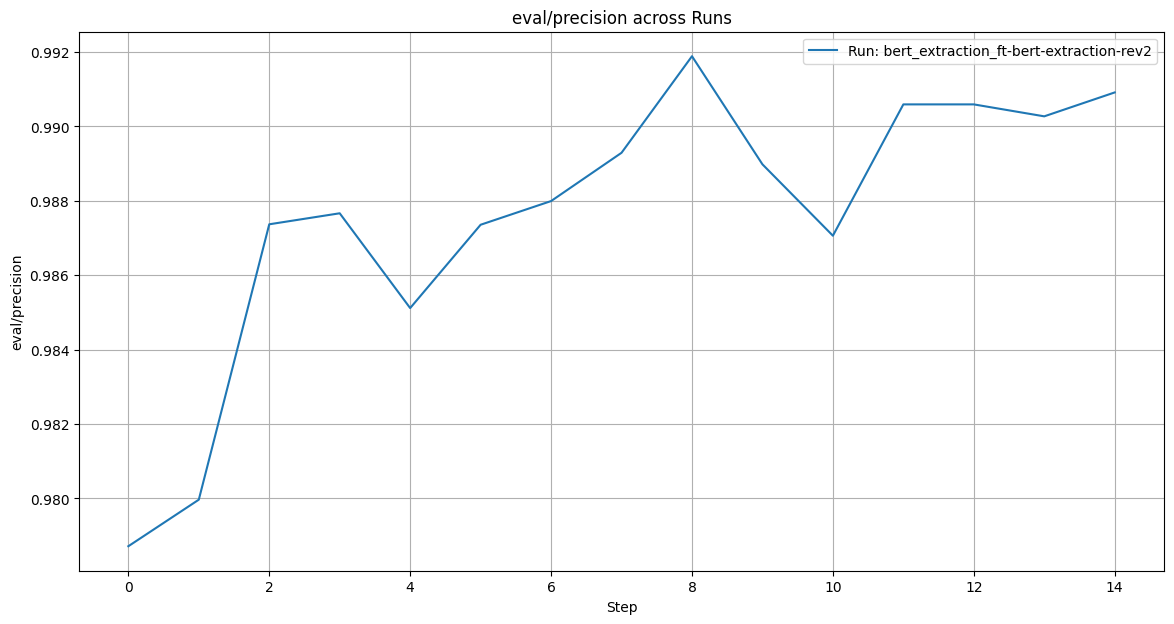

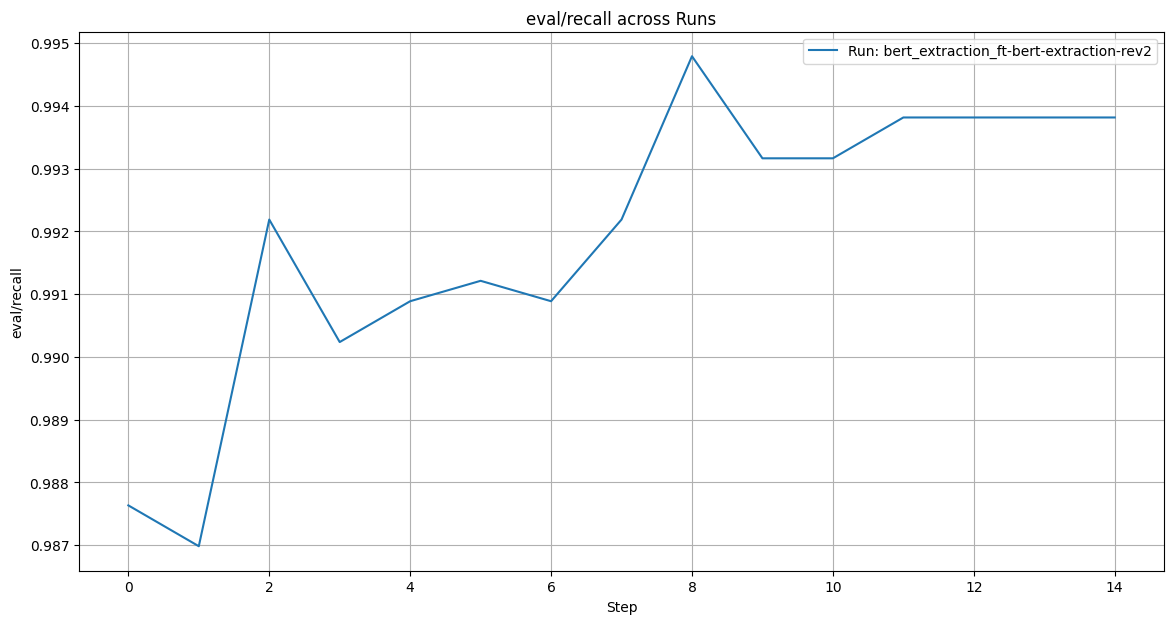

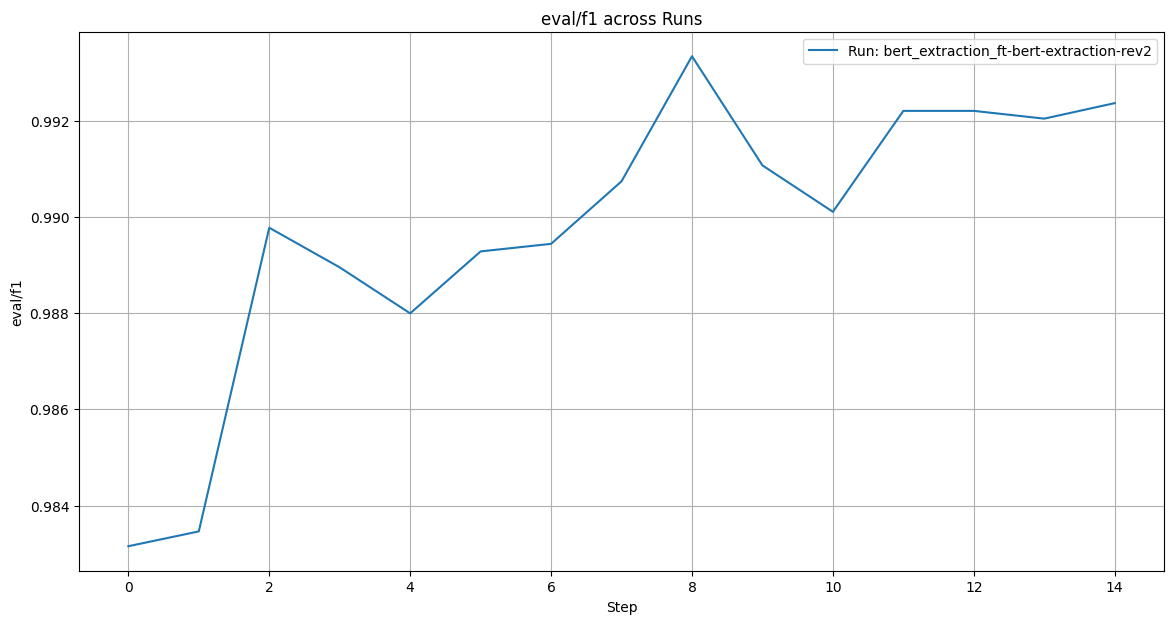

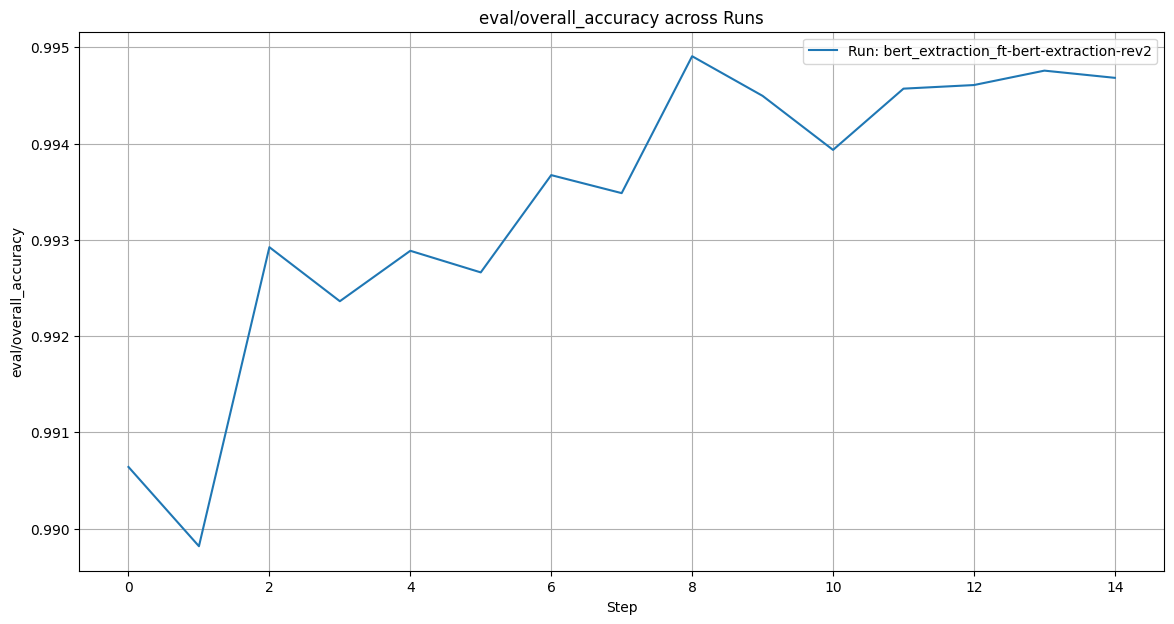

In [5]:
plot_runs_data(runs, "eval/loss")
plot_runs_data(runs, "eval/precision")
plot_runs_data(runs, "eval/recall")
plot_runs_data(runs, "eval/f1")
plot_runs_data(runs, "eval/overall_accuracy")

## Summary
I omitted detailed statistics for every label type, because it would be too much to show in a readable way. \
Model results are looking very well, with almost perfect accuracy. At first, it looks like the model \
was starting to overfit, but then the loss stabilized, and accuracy went up.

Below I present a proof that the model is indeed working well.

In [6]:
def __align_labels_with_tokens(labels: list, word_ids: list, bi_split: bool) -> list[int]:
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            if not bi_split:
                if label > 0: # If the label is not O or N/A
                    label = 2*label - 1 # Change it to B-XXX
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else: # Same word as previous token
            label = labels[word_id]
            if not bi_split:
                label = 2*label
            else: # Adjust so that one word has only one B-X token.
                if label%2 == 1: # I-X are even; Unknown is even also. B-X is odd.
                    label += 1 # from (2*label)-1 to 2*label
            new_labels.append(label)

    return new_labels

In [9]:
model = AutoModelForTokenClassification.from_pretrained("zpp-murmuras/bert-extraction-rev2", token=hf_token)
dataset = load_dataset("zpp-murmuras/bert-extraction-ds", token=hf_token)
tokenizer = AutoTokenizer.from_pretrained("zpp-murmuras/bert-extraction-rev2", token=hf_token)

sample = dataset['dm']
text_input = sample["texts"][11]
label_input = sample["labels"][11]
print(f"Text data: {text_input}")
print(f"Labels data: {label_input}")


tokenized_input = tokenizer(text_input, is_split_into_words=True, return_tensors="pt")
word_ids = tokenized_input.word_ids(batch_index=0)
prepared_labels = __align_labels_with_tokens(label_input, word_ids, True)
pred2 = model(**tokenized_input)
logits = pred2.logits
predicted_labels = torch.argmax(logits, axis=2)
total = 0
correct = 0
for a, b in zip(prepared_labels, predicted_labels[0]):
    if a == b:
        correct += 1
print(f"Accuracy: {correct/len(prepared_labels)}")

Text data: ['Gültig bis 30.11.2024', 'Gilt für beliebig viele Artikel innerhalb eines Einkaufs', '30%', 'Coupon aktivieren', 'Rasierklingen der Marken BULLDOG, WILKINSON SWORD & WILKINSON Intuition']
Labels data: [5, 0, 3, 7, 1]
Accuracy: 0.967741935483871


It seems that on my PC Jupiter goes crazy and repeats everything twice. Still, the model is working well.